In [60]:
import re
import pickle
import pandas as pd
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
dataset = pd.read_csv('C:/Users/USER/Desktop/malay/malaydata.csv')

Axes(0.125,0.11;0.775x0.77)


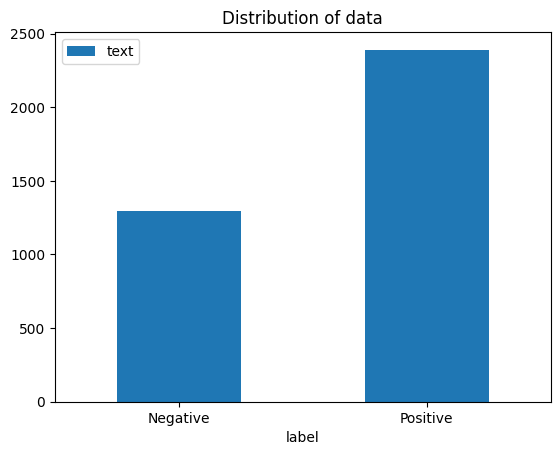

In [62]:
dataset = dataset[['label','text']]

# Plotting the distribution for dataset.
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=True)

ax.set_xticklabels(['Negative','Positive'], rotation=0)

print(ax)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['label'])

In [89]:
# Assuming 'label' values are 'Positive' and 'Negative'
positive_count = dataset['label'].value_counts().get('Positive', 0)
negative_count = dataset['label'].value_counts().get('Negative', 0)

print("Total Positive Data:", positive_count)
print("Total Negative Data:", negative_count)

Total Positive Data: 2390
Total Negative Data: 1295


In [63]:
label_to_polarity = {'Positive': 1, 'Negative': -1}

# Apply the sentiment_analysis function to the 'label' column
dataset['polarity'] = dataset['label'].apply(lambda x: label_to_polarity[x])

In [64]:
dataset.head(5)

,label,text,polarity
0,Negative,Lebih-lebih lagi dengan kemudahan internet da...,-1
1,Positive,boleh memberi teguran kepada parti tetapi perl...,1
2,Negative,Adalah membingungkan mengapa masyarakat Cina b...,-1
3,Positive,Kami menurunkan defisit daripada 6.7 peratus p...,1
4,Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem",-1


<Axes: >

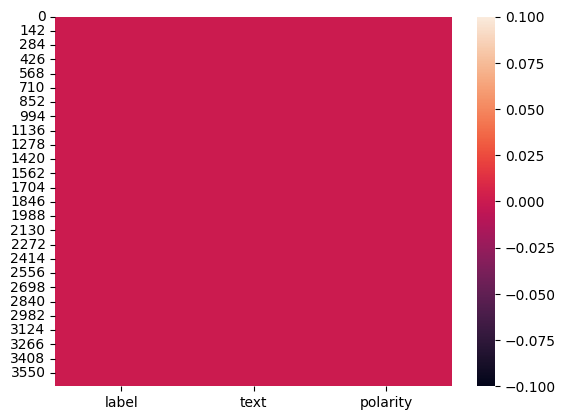

In [65]:
sns.heatmap(dataset.isnull())

## Exploratory Data Analysis

#### Data Cleaning

In [66]:
## Defining set containing all stopwords in malay
stopwordlist = ['acap', 'acap kali', 'adakala', 'adakalanya', 'adalah', 'adapun', 'adoi', 'aduh', 'aduhai',
                'agak agaknya', 'agar', 'alamak', 'alhasil', 'alkisah', 'amat', 'amboi', 'andai', 'andai kata', 'aneka',
                'antara', 'apa', 'apabila', 'apakala', 'apa lagi', 'arkian', 'atau', 'au', 'auh', 'ayuh', 'ayuhai',
                'bagai', 'bagaimana', 'bagaimanapun', 'bagi', 'bahawa', 'bahawasanya', 'bahkan', 'banyak', 'barangkali',
                'beberapa', 'belum', 'benar', 'berapa', 'betul', 'bila', 'bila mana', 'boleh', 'boleh jadi', 'buat',
                'bukan', 'dalam', 'dan', 'dapat', 'dari', 'darihal', 'daripada', 'demi', 'dengan', 'di', 'ee', 'eh',
                'ehem', 'enggan', 'entah', 'entahkan', 'gamaknya', 'ha', 'haah', 'hanya', 'harapnya', 'harus', 'hatta',
                'hei', 'helo', 'hendak', 'hingga', 'ialah', 'jangan', 'jemput', 'jika', 'jikalau', 'jua', 'juga',
                'kadang', 'kadangkala', 'kelakian', 'kalau', 'ke', 'kemudian', 'kenapa', 'kendatipun', 'kepada',
                'kerana', 'ketika', 'kian', 'lagi', 'lagikan', 'laksana', 'lalu', 'macam', 'maha', 'mahu', 'mahupun',
                'maka', 'malah', 'malahan', 'mana', 'manakala', 'mana lagi', 'masih', 'masing-masing', 'memang',
                'mengapa', 'meskipun', 'mesti', 'minta', 'misal', 'mungkin', 'nampaknya', 'namun', 'nan', 'nian', 'nun',
                'oh', 'oleh', 'oleh itu', 'pabila', 'pada', 'padahal', 'paling', 'para', 'pelbagai', 'perlu', 'pernah',
                'pun', 'sahaja', 'saja', 'sambil', 'sampai', 'sangat', 'sebab', 'sebagai', 'sebagaimana', 'sebermula',
                'sedang', 'sedikit', 'segala', 'sejak', 'sekali', 'sekali peristiwa', 'sekalian', 'sekiranya', 'selalu',
                'seluruh', 'semasa', 'sementara', 'semoga', 'semua', 'seperti', 'serba', 'serta', 'sesungguhnya',
                'setelah', 'setiap', 'sewaktu', 'siapa', 'sila', 'sudah', 'sungguh', 'sungguhpun', 'supaya', 'syabas',
                'syahadan', 'tatkala', 'telah', 'tentang', 'terhadap', 'terlalu', 'tetapi', 'tiap-tiap', 'tidak',
                'tolong', 'umpama', 'untuk', 'usah', 'wah', 'wahai', 'walau', 'walaupun', 'yang']

In [ ]:
# Read stopwords from the file
with open('stopwords-ms.txt', 'r') as file:
    stopwords = set(word.strip() for word in file)

In [67]:
# Create Lemmatizer
word_lemmatizer = WordNetLemmatizer()

# Create Sastrawi stemmer
stemmer = StemmerFactory().create_stemmer()

def preprocess_and_stem(dataset):
    # Convert to lowercase
    dataset = dataset.lower()

    # Replace URLs with 'URL'
    dataset = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', 'URL', dataset)

    # Remove mentions
    dataset = re.sub(r'@[^\s]+', '', dataset)

    # Remove non-alphanumeric characters and extra spaces
    dataset = re.sub(r'[^a-zA-Zа-яА-Я1-9]+', ' ', dataset)
    dataset = re.sub(r' +', ' ', dataset)

    # Tokenize and lemmatize
    words = dataset.split()
    lemmatized_words = [word_lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words with a space between them
    processed_text = ' '.join(lemmatized_words)

    # Apply stemming
    stemmed_text = stemmer.stem(processed_text)

    return stemmed_text

In [68]:
dataset['cleaned_text'] = dataset['text'].apply(preprocess_and_stem)

In [69]:
dataset

,label,text,polarity,cleaned_text
0,Negative,Lebih-lebih lagi dengan kemudahan internet da...,-1,lebih lebih lagi dengan mudah internet dan lam...
1,Positive,boleh memberi teguran kepada parti tetapi perl...,1,boleh beri tegur kepada parti tetapi perlu iku...
2,Negative,Adalah membingungkan mengapa masyarakat Cina b...,-1,adalah bingung mengapa masyarakat cina sorak g...
3,Positive,Kami menurunkan defisit daripada 6.7 peratus p...,1,kami turun defisit daripada 6 7 atus pada tahu...
4,Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem",-1,ini masalah bukan rakyat tetapi sistem
...,...,...,...,...
3680,Positive,Jelas pembangkang buat tuduhan untuk mengeliru...,1,jelas bangkang buat tuduh untuk keliru rakyat ...
3681,Positive,demokrasi adalah kuasa rakyat di mana pegawai ...,1,demokrasi adalah kuasa rakyat di mana pegawai ...
3682,Positive,"Selain dapat menyelesaikan isu beg berat, peng...",1,selain dapat selesai isu beg berat guna buku t...
3683,Positive,Hospital Langkawi buat masa ini hanya dapat me...,1,hospital langkawi buat masa ini hanya dapat ta...


## WORDCLOUD

In [70]:
import time
import nltk
nltk.download('wordnet')


t = time.time()
dataset['cleaned_text'] = dataset['text'].apply(preprocess_and_stem)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text Preprocessing complete.
Time Taken: 1 seconds


In [71]:
positive_data = dataset[dataset['polarity'] == 1]['cleaned_text']
negative_data = dataset[dataset['polarity'] == -1]['cleaned_text']

In [72]:
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(['URL']), 
                min_font_size = 10).generate(' '.join(data))
    
    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

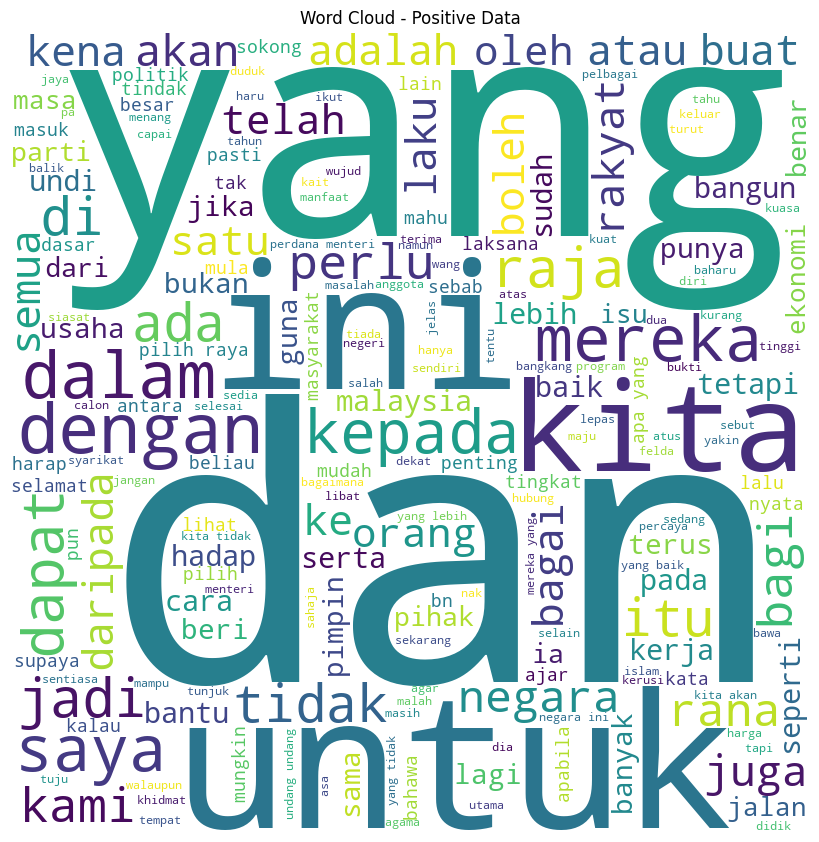

In [73]:
# Generate word cloud for positive data
generate_wordcloud(positive_data, 'Word Cloud - Positive Data')

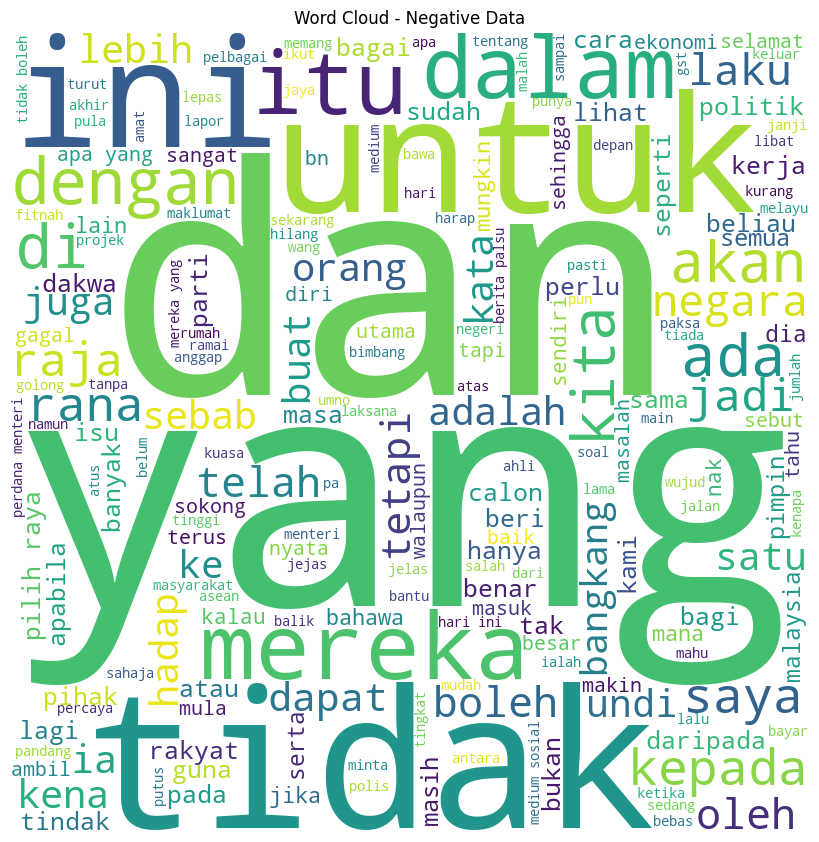

In [74]:
# Generate word cloud for negative data
generate_wordcloud(negative_data, 'Word Cloud - Negative Data')

## Data Modelling

In [75]:
X = dataset["cleaned_text"]
y = dataset["label"]

In [76]:
#Splitting the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123, stratify=y)

In [91]:
# Display counts and ratios
total_data_points = len(dataset)
training_data_count = len(X_train)
testing_data_count = len(X_test)

print("Total Data Points:", total_data_points)
print("Training Data Count:", training_data_count)
print("Testing Data Count:", testing_data_count)

print("\nTraining Data Ratio:", training_data_count / total_data_points)
print("Testing Data Ratio:", testing_data_count / total_data_points)

Total Data Points: 3685
Training Data Count: 2763
Testing Data Count: 922

Training Data Ratio: 0.7497964721845319
Testing Data Ratio: 0.2502035278154681


In [77]:
#Function to calculate evaluation scores on train set
def train_scores(gs, X, y):
    pred = gs.predict(X)
    print('Train scores')
    print('--------------------------')
    print(f'F1 score: {round(f1_score(y, pred, average = "weighted"), 4)}')
    print('--------------------------')
    print(f'Recall score: {round(recall_score(y, pred, average = "weighted"), 4)}')
    print(f'Precision score: {round(precision_score(y, pred, average = "weighted"), 4)}')
    print(f'Accuracy score: {round(accuracy_score(y, pred), 4)}')

In [78]:
#Function to calculate evaluation scores on test set
def test_scores(gs, X, y):
    pred = gs.predict(X)
    print('Test scores')
    print('--------------------------')
    print(f'F1 score: {round(f1_score(y, pred, average = "weighted"), 4)}')
    print('--------------------------')
    print(f'Recall score: {round(recall_score(y, pred, average = "weighted"), 4)}')
    print(f'Precision score: {round(precision_score(y, pred, average = "weighted"), 4)}')
    print(f'Accuracy score: {round(accuracy_score(y, pred), 4)}')

In [79]:
#Instantiate pipeline 
pipe = SklearnPipeline([('tvec', TfidfVectorizer()), 
                        ('nb', MultinomialNB())])

In [80]:
#Setting pipe parameters
pipe_params={'tvec__min_df': [10],
             'tvec__max_df': [0.90, 0.95],
             'tvec__ngram_range': [(1,1), (1,2)],
             'nb__alpha': [0.0001, 0.001, 0.005, 0.01, 0.1, 1]}

In [81]:
#Instantiate Gridsearch
gs1=GridSearchCV(pipe,
                param_grid=pipe_params,
                scoring = 'f1_micro',
                cv=5)


In [82]:
#Train model
gs1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.0001, 0.001, 0.005, 0.01, 0.1, 1],
                         'tvec__max_df': [0.9, 0.95], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_micro')

In [83]:
train_scores(gs1, X_train, y_train)

Train scores
--------------------------
F1 score: 0.796
--------------------------
Recall score: 0.8067
Precision score: 0.8104
Accuracy score: 0.8067


In [84]:
test_scores(gs1, X_test, y_test)

Test scores
--------------------------
F1 score: 0.7043
--------------------------
Recall score: 0.7267
Precision score: 0.7202
Accuracy score: 0.7267


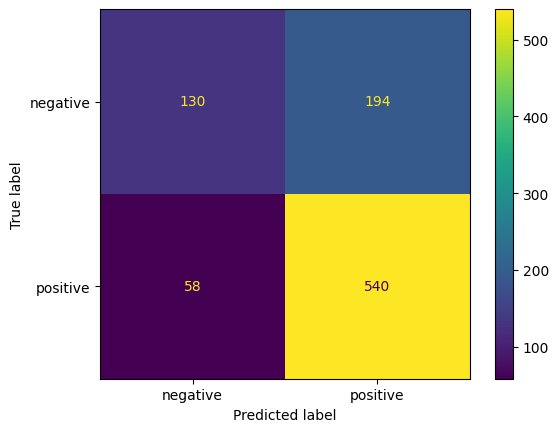

In [85]:
class_labels = ['negative', 'positive']
pred = gs1.predict(X_test)
# Create the confusion matrix
cm = confusion_matrix(y_test, pred)

# Create the ConfusionMatrixDisplay with display_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
disp.plot()
plt.show()

In [86]:
gs1.best_params_

{'nb__alpha': 0.01,
 'tvec__max_df': 0.9,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [87]:
def train_and_save_models(cleaned_dataset, label_to_polarity):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(cleaned_dataset, label_to_polarity, test_size=0.2, random_state=42)

    # Use TfidfVectorizer on the entire dataset
    vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore')
    X_transformed = vectorizer.fit_transform(X_train)

    # Train the Multinomial Naive Bayes model on the training set
    model = MultinomialNB()
    model.fit(X_transformed, y_train)

    # Get the current working directory
    current_directory = os.getcwd()

   # Save the vectorizer to a pickle file
with open('TfidfVectorizer.pickle', 'wb') as file:
    pickle.dump(gs1.best_estimator_.named_steps['tvec'], file)

# Save the model to a pickle file
with open('MultinomialNB.pickle', 'wb') as file:
    pickle.dump(gs1.best_estimator_.named_steps['nb'], file)

In [88]:
# Load the models from a pickle file
def load_models():
    # Load the vectorizer from a pickle file
    with open('TfidfVectorizer.pickle', 'rb') as file:
        vectorizer = pickle.load(file)

    # Load the model from a pickle file
    with open('MultinomialNB.pickle', 'rb') as file:
        model = pickle.load(file)

    return vectorizer, model